<a href="https://colab.research.google.com/github/m-evdokimov/dls-image-classification/blob/main/vit_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification (ViT, part 2)

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/best-val-model.pt best-val-model.pt

In [ ]:
!nvidia-smi

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
import tqdm

from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTConfig
from transformers import get_cosine_schedule_with_warmup

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Training ViT from scratch

In [ ]:
# init model and feature extractor
cfg = ViTConfig(**{"id2label": {
                      "0": "LABEL_0",
                      "1": "LABEL_1",
                      "2": "LABEL_2",
                      "3": "LABEL_3",
                      "4": "LABEL_4",
                      "5": "LABEL_5",
                      "6": "LABEL_6",
                      "7": "LABEL_7",
                      "8": "LABEL_8",
                      "9": "LABEL_9"
                    },
                    "label2id": {
                      "LABEL_0": 0,
                      "LABEL_1": 1,
                      "LABEL_2": 2,
                      "LABEL_3": 3,
                      "LABEL_4": 4,
                      "LABEL_5": 5,
                      "LABEL_6": 6,
                      "LABEL_7": 7,
                      "LABEL_8": 8,
                      "LABEL_9": 9}},
                image_size=32,
                num_hidden_layers=4,
                num_attention_heads=4,
                patch_size=4,
                )

model = ViTForImageClassification(cfg).to(device)
feature_extractor = ViTFeatureExtractor(size=32, image_std=[0.2472, 0.2437, 0.2617], image_mean=[0.4915, 0.4821, 0.4464])

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='/content/cifar10_train', train=True, download=True)
test_data = torchvision.datasets.CIFAR10(root='/content/cifar10_test', train=False, download=True,)

In [ ]:
def vit_collate_fn(data):
  global feature_extractor
  batch_size = len(data)
  inputs = feature_extractor([x[0] for x in data], return_tensors='pt')['pixel_values']
  labels = []
  for i in range(batch_size):
    labels.append(data[i][1])
  return inputs, torch.LongTensor(labels)

In [ ]:
BATCH_SIZE = 256

train_subset = Subset(train_data, np.arange(int(len(train_data) * 0.9)))
val_subset = Subset(train_data, np.arange(int(len(train_data) * 0.9), len(train_data)))

train_loader = DataLoader(train_subset, BATCH_SIZE, shuffle=True, collate_fn=vit_collate_fn)
val_loader = DataLoader(val_subset, BATCH_SIZE, shuffle=False, collate_fn=vit_collate_fn)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False, collate_fn=vit_collate_fn)

In [ ]:
def train(model, optimizer, criterion, CLIP, train_loader):
  global device
  model.train()
  train_true_predicted = 0 
  train_size = 0.
  train_loss = 0.


  for batch in tqdm.tqdm(train_loader, position=0, leave=True):
    inputs = batch[0].to(device)
    labels = batch[1].to(device)

    output = model(inputs)['logits']
    pred_labels = torch.argmax(output, dim=-1)

    optimizer.zero_grad()
    loss = criterion(output, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
    optimizer.step()

    train_loss += loss.item()
    train_true_predicted += (labels == pred_labels).sum()
    train_size += int(labels.shape[0])


  avg_train_loss = float(train_loss / len(train_loader))
  train_acc = float(train_true_predicted / train_size)
  return avg_train_loss, train_acc

In [ ]:
def evaluate(model, criterion, val_loader):
  global device
  model.eval()
  val_true_predicted = 0
  val_size = 0.
  val_loss = 0.

  with torch.no_grad():    
    for batch in tqdm.tqdm(val_loader, position=0, leave=True):
      inputs = batch[0].to(device)
      labels = batch[1].to(device)

      output = model(inputs)['logits']

      val_loss += criterion(output, labels).item()

      pred_labels = torch.argmax(output, dim=-1)
      val_true_predicted += (labels == pred_labels).sum()
      val_size += int(labels.shape[0])


  avg_val_loss = float(val_loss / len(val_loader))
  val_acc = float(val_true_predicted / val_size)
  return avg_val_loss, val_acc

In [ ]:
def inference(model, test_loader):
  global device
  model.eval()
  test_true_predicted = 0.
  test_size = 0.

  with torch.no_grad():
    for batch in tqdm.tqdm(test_loader, position=0, leave=True):
      inputs = batch[0].to(device)
      labels = batch[1]

      output = model(inputs)['logits']
      pred_labels = torch.argmax(output, dim=-1)
      test_true_predicted += (labels == pred_labels.cpu()).sum()
      test_size += int(labels.shape[0])

  test_acc = test_true_predicted / test_size
  return float(test_acc)

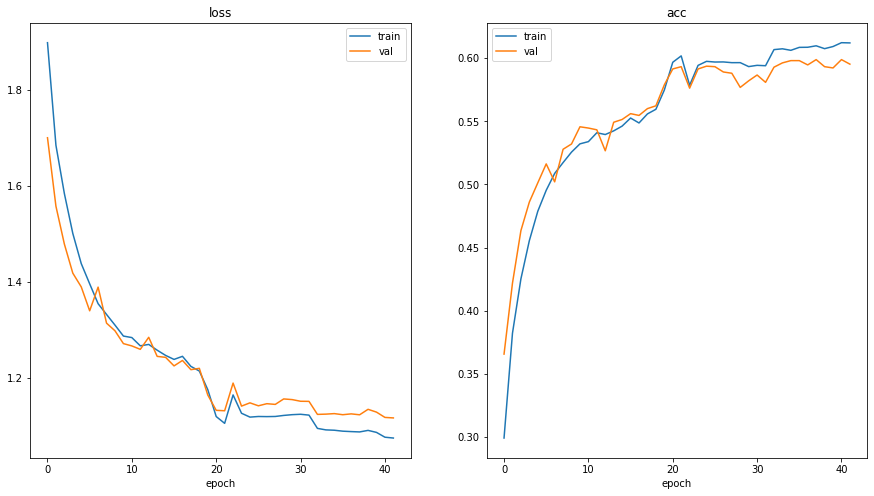

train_loss: 1.0755, val_loss: 1.1173, val_acc 0.5952


  6%|▌         | 5/88 [00:11<03:12,  2.32s/it]

KeyboardInterrupt: ignored

In [ ]:
N_EPOCHS = 60
CLIP = 3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5 , weight_decay=3e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []
best_valid_loss = float('inf')


for epoch in range(N_EPOCHS):

  # simple warmup
  if epoch == 0:
    for g in optimizer.param_groups:
      g['lr'] = 5e-7
  if epoch == 1:
    for g in optimizer.param_groups:
      g['lr'] = 2e-5

  avg_train_loss, train_acc = train(model, optimizer, criterion, CLIP, train_loader)
  avg_val_loss, val_acc = evaluate(model, criterion, val_loader)
  train_loss_history.append(avg_train_loss)
  train_acc_history.append(train_acc)
  val_loss_history.append(avg_val_loss)
  val_acc_history.append(val_acc)
  scheduler.step()
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

  clear_output(True)
  ax[0].plot(train_loss_history, label='train')
  ax[0].plot(val_loss_history, label='val')
  ax[0].set_xlabel('epoch')
  ax[0].set_title('loss')
  ax[0].legend()

  ax[1].plot(train_acc_history, label='train')
  ax[1].plot(val_acc_history, label='val')
  ax[1].set_xlabel('epoch')
  ax[1].set_title('acc')
  ax[1].legend()
  plt.show()

  print('train_loss: {:.5}, val_loss: {:.5}, val_acc {:.4}'.format(avg_train_loss, avg_val_loss, val_acc))

  if avg_val_loss < best_valid_loss:
    best_valid_loss = avg_val_loss
    torch.save(model.state_dict(), 'best-val-model.pt')
    !cp best-val-model.pt /content/drive/MyDrive/best-val-model.pt 

In [ ]:
inference(model, test_loader)

100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


0.5856000185012817

**Found out that ViT as a complex model cannot be trained on small datesets properly. So let's try to fine-tune it**

# Fine-tuned model pretrained on ImageNet

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

model.classifier = torch.nn.Linear(in_features=768, out_features=10)

for param in model.vit.embeddings.parameters():
  param.requires_grad = False

for param in model.vit.encoder.parameters():
  param.requires_grad = False

model.to(device);

In [ ]:
BATCH_SIZE = 128

train_subset = Subset(train_data, np.arange(int(len(train_data) * 0.9)))
val_subset = Subset(train_data, np.arange(int(len(train_data) * 0.9), len(train_data)))

train_loader = DataLoader(train_subset, BATCH_SIZE, shuffle=True, collate_fn=vit_collate_fn)
val_loader = DataLoader(val_subset, BATCH_SIZE, shuffle=False, collate_fn=vit_collate_fn)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False, collate_fn=vit_collate_fn)

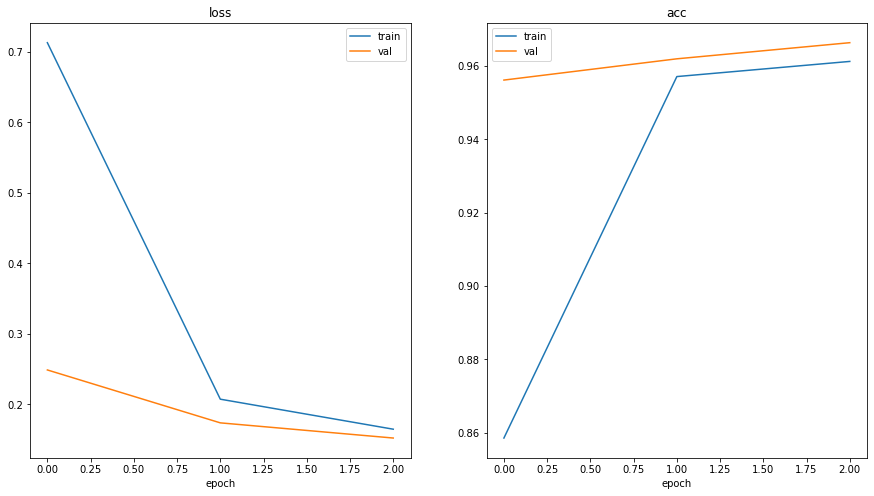

train_loss: 0.16459, val_loss: 0.15204, val_acc 0.9664


In [ ]:
N_EPOCHS = 3
CLIP = 3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 , weight_decay=3e-2)


train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []
best_valid_loss = float('inf')


for epoch in range(N_EPOCHS):

  avg_train_loss, train_acc = train(model, optimizer, criterion, CLIP, train_loader)
  avg_val_loss, val_acc = evaluate(model, criterion, val_loader)
  train_loss_history.append(avg_train_loss)
  train_acc_history.append(train_acc)
  val_loss_history.append(avg_val_loss)
  val_acc_history.append(val_acc)
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

  clear_output(True)
  ax[0].plot(train_loss_history, label='train')
  ax[0].plot(val_loss_history, label='val')
  ax[0].set_xlabel('epoch')
  ax[0].set_title('loss')
  ax[0].legend()

  ax[1].plot(train_acc_history, label='train')
  ax[1].plot(val_acc_history, label='val')
  ax[1].set_xlabel('epoch')
  ax[1].set_title('acc')
  ax[1].legend()
  plt.show()

  print('train_loss: {:.5}, val_loss: {:.5}, val_acc {:.4}'.format(avg_train_loss, avg_val_loss, val_acc))

In [ ]:
inference(model, test_loader)

100%|██████████| 79/79 [04:57<00:00,  3.77s/it]


0.960099995136261